In [1]:
import itertools
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy

import seaborn
seaborn.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 2}, font='DejaVu Serif')

from joblib import Parallel, delayed

In [2]:
%cd ../adith/
import Datasets
import Metrics
import MF
import BMF
%cd ../dawen/

/home/dliang/nmar-factorization/adith
/home/dliang/nmar-factorization/dawen


In [3]:
np.random.seed(98765)

### Get the ML100K dataset and train a best MF (in terms of completion)

In [4]:
def ML100K_train_test_split(repo_path, prop=0.1, verbose=False):
    f = open(repo_path + "/evaluation/exp/data/u.data", 'r')
    rows = []
    cols = []
    vals = []
    numUsers = 0
    numItems = 0
    for line in f:
        tokens = line.strip().split('\t')
        rowIndex = int(tokens[0])-1
        colIndex = int(tokens[1])-1
        rows.append(rowIndex)
        cols.append(colIndex)
        vals.append(int(tokens[2]))
        
        if rowIndex >= numUsers:
            numUsers = rowIndex + 1
        if colIndex >= numItems:
            numItems = colIndex + 1
            
    f.close()
    
    numRatings = len(vals)
    rows = numpy.array(rows)
    cols = numpy.array(cols)
    vals = numpy.array(vals)
    
    if verbose:
        print "Datasets.ML100K: [DBG]\t NumUsers,NumItems,NumObservations:", numUsers, numItems, numRatings
    
    shuffleOrder = numpy.random.permutation(numRatings)
    testFraction = int(prop * numRatings)
    
    testIndices = shuffleOrder[0:testFraction]
    testRows = rows[testIndices]
    testCols = cols[testIndices]
    testVals = vals[testIndices]
    testMatrix = scipy.sparse.coo_matrix((testVals, (testRows,testCols)), shape = (numUsers, numItems),
                        dtype = numpy.int)
    testMatrix = testMatrix.toarray()
    
    #Finish loading the training set ratings
    trainIndices = shuffleOrder[testFraction:]
    trainRows = rows[trainIndices]
    trainCols = cols[trainIndices]
    trainVals = vals[trainIndices]
    trainMatrix = scipy.sparse.coo_matrix((trainVals, (trainRows,trainCols)), shape = (numUsers, numItems),
                        dtype = numpy.int)
    trainMatrix = trainMatrix.toarray()
    return trainMatrix, testMatrix

In [5]:
trainMatrix, testMatrix = ML100K_train_test_split('../', 0.1, True)

Datasets.ML100K: [DBG]	 NumUsers,NumItems,NumObservations: 943 1682 100000


In [6]:
ratingMarginals = Datasets.RATING_MARGINALS_R3_UNIF('../')

In [7]:
ratingCumulative = np.cumsum(ratingMarginals, dtype = np.float)

In [8]:
lambdas = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]
dims = [5,10,20,40,80]
paramSettings = list(itertools.product(lambdas, dims))

In [9]:
def MF_generate_matrix_wrapper(train_matrix, l2, n_dims):
    model = MF.GENERATE_MATRIX(train_matrix, None, l2, 'MSE', 0, None, n_dims)
    return ((l2, n_dims), model)

In [10]:
modelsPerLambda = Parallel(n_jobs=10)(delayed(MF_generate_matrix_wrapper)(trainMatrix, l2Lambda[0], l2Lambda[1])
                                     for l2Lambda in paramSettings)

In [11]:
def raw_to_ratings(complete_raw_scores, cumulative_rating):
    currentCompleteTestMatrix = np.empty_like(complete_raw_scores, dtype=np.int)
    sortedScores = np.sort(complete_raw_scores, axis=None)
    numEntries = sortedScores.size
    checkPoints = [sortedScores[0]] + [sortedScores[int(cumulative_rating[i] * numEntries) - 1] for i in range(5)]
    
    for i in range(1,6):
        mask = np.logical_and(complete_raw_scores >= checkPoints[i-1], complete_raw_scores <= checkPoints[i])
        currentCompleteTestMatrix[mask] = i
    return currentCompleteTestMatrix

In [12]:
def compute_num_matches(test_matrix, model, cumulative_rating):
    completeScores = MF.PREDICTED_SCORES(*model)
    currentCompleteTestMatrix = raw_to_ratings(completeScores, cumulative_rating)
        
    #Now check the quality of this completion
    checkIndices = numpy.where(test_matrix > 0)
    discrepancy = currentCompleteTestMatrix[checkIndices] - test_matrix[checkIndices]
    numMatches = numpy.sum(discrepancy == 0, dtype = numpy.int)
    return numMatches

In [13]:
best_param = None
best_num_matches = -1

for model in modelsPerLambda:
    pred = MF.PREDICTED_SCORES(*model[1])
    num_matches = compute_num_matches(testMatrix, model[1], ratingCumulative)
    print("l2=%.3e\tn_dims=%d\tnum_mathces=%d out of %d" % (model[0][0], model[0][1], num_matches, (testMatrix > 0).sum()))
    if num_matches >= best_num_matches:
        best_num_matches = num_matches
        best_param = model

l2=1.000e-06	n_dims=5	num_mathces=1339 out of 10000
l2=1.000e-06	n_dims=10	num_mathces=1256 out of 10000
l2=1.000e-06	n_dims=20	num_mathces=1333 out of 10000
l2=1.000e-06	n_dims=40	num_mathces=1729 out of 10000
l2=1.000e-06	n_dims=80	num_mathces=1919 out of 10000
l2=1.000e-05	n_dims=5	num_mathces=1999 out of 10000
l2=1.000e-05	n_dims=10	num_mathces=1873 out of 10000
l2=1.000e-05	n_dims=20	num_mathces=1940 out of 10000
l2=1.000e-05	n_dims=40	num_mathces=1986 out of 10000
l2=1.000e-05	n_dims=80	num_mathces=2132 out of 10000
l2=1.000e-04	n_dims=5	num_mathces=2317 out of 10000
l2=1.000e-04	n_dims=10	num_mathces=2348 out of 10000
l2=1.000e-04	n_dims=20	num_mathces=2307 out of 10000
l2=1.000e-04	n_dims=40	num_mathces=2299 out of 10000
l2=1.000e-04	n_dims=80	num_mathces=2301 out of 10000
l2=1.000e-03	n_dims=5	num_mathces=2262 out of 10000
l2=1.000e-03	n_dims=10	num_mathces=2254 out of 10000
l2=1.000e-03	n_dims=20	num_mathces=2252 out of 10000
l2=1.000e-03	n_dims=40	num_mathces=2264 out of 100

In [14]:
print("The best model: l2=%.3e\tn_dims=%d" % best_param[0])

The best model: l2=1.000e+00	n_dims=80


### Generate synthetic data with the learned parameter and flip the predicted raw ratings except top 10 movies per user

In [15]:
complete_raw_ratings = MF.PREDICTED_SCORES(*best_param[1])

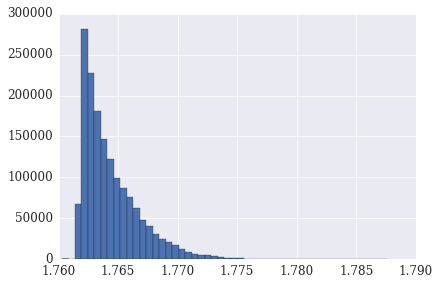

In [17]:
plt.hist(complete_raw_ratings.ravel(), bins=50)
pass

The predicted ratings are mostly around 1.75, which is bad

In [18]:
# for each user, keep the score for the top n_recs unchanged and flip the sign for the rest
n_recs = 10

In [19]:
n_users, n_items = complete_raw_ratings.shape

In [20]:
idx_sorted = np.argsort(complete_raw_ratings, axis=1)

In [21]:
flipped_raw_ratings = complete_raw_ratings.copy()
flipped_raw_ratings[np.arange(n_users)[:, np.newaxis], idx_sorted[:, :-n_recs]] *= -1

In [22]:
complete_flipped_ratings = raw_to_ratings(flipped_raw_ratings, ratingCumulative)
complete_org_ratings = raw_to_ratings(complete_raw_ratings, ratingCumulative)

In [23]:
alpha = 0.25
partial_flipped_observation, gpro_flipped = Datasets.PARTIAL_OBSERVE(complete_flipped_ratings, alpha, 0.01, True) 

Datasets.PARTIAL_OBSERVE: [LOG]	 Histogram of complete ratings: [834683 383725 228226  99015  40477] 	 Alpha: 0.25 	 Sparsity: 0.01
Datasets.PARTIAL_OBSERVE: [DBG]	 PropensityPerRating: [ 0.00106105  0.00424419  0.01697675  0.06790701  0.06790701] 	 NumObservations/ExpectedObservations: 15861.26 233573.234375
Datasets.PARTIAL_OBSERVE: [DBG]	 Histogram of observed ratings: [ 840 1619 3829 6678 2822]


In [24]:
partial_org_observation, gpro_org = Datasets.PARTIAL_OBSERVE(complete_org_ratings, alpha, 0.01, True)

Datasets.PARTIAL_OBSERVE: [LOG]	 Histogram of complete ratings: [834683 383725 228226  99015  40477] 	 Alpha: 0.25 	 Sparsity: 0.01
Datasets.PARTIAL_OBSERVE: [DBG]	 PropensityPerRating: [ 0.00106105  0.00424419  0.01697675  0.06790701  0.06790701] 	 NumObservations/ExpectedObservations: 15861.26 233573.234375
Datasets.PARTIAL_OBSERVE: [DBG]	 Histogram of observed ratings: [ 879 1667 3953 6799 2721]


In [25]:
gpro_inv_flipped = 1. / gpro_flipped
gpro_inv_org = 1. / gpro_org

### Compare MF and BMF

We compare MF and BMF on both the original ratings and flipped ratings

In [26]:
mu = best_param[0][0]
numDims = best_param[0][1]
numRecs = n_recs

currMetric = Metrics.CG

Scenario 1: Propensity weighted MF on flipped ratings

In [45]:
mask_flipped = (partial_flipped_observation > 0)

In [46]:
params_mf_flipped = MF.GENERATE_MATRIX(partial_flipped_observation, gpro_inv_flipped, mu, 'MSE', 0, None, numDims, False)
pred_mf_flipped = MF.PREDICTED_SCORES(*params_mf_flipped)

In [47]:
# Derive policy
policy_mf_flipped = np.zeros_like(pred_mf_flipped, dtype=np.longdouble)
selectedItems = np.argsort(-pred_mf_flipped, axis = 1)[:,0:numRecs]
policy_mf_flipped[np.arange(n_users)[:, np.newaxis], selectedItems[:, :numRecs]] = 1

In [48]:
metricValue = currMetric(complete_flipped_ratings, policy_mf_flipped, None)[0]
metricValue = metricValue / numRecs
print "PolicyOpt: [LOG] MF on flipped (unmasking training set) \t Eventual result:", metricValue

PolicyOpt: [LOG] MF on flipped (unmasking training set) 	 Eventual result: 5.0


In [31]:
# mask the training set
pred_mf_flipped[mask_flipped] = -np.inf

policy_mf_flipped = np.zeros_like(pred_mf_flipped, dtype=np.longdouble)
selectedItems = np.argsort(-pred_mf_flipped, axis = 1)[:,0:numRecs]
policy_mf_flipped[np.arange(n_users)[:, np.newaxis], selectedItems[:, :numRecs]] = 1

In [32]:
metricValue = currMetric(complete_flipped_ratings, policy_mf_flipped, None)[0]
metricValue = metricValue / numRecs
print "PolicyOpt: [LOG] MF on flipped (masking training set) \t Eventual result:", metricValue

PolicyOpt: [LOG] MF on flipped (masking training set) 	 Eventual result: 4.80604453871


Scenario 2: Propensity weighted MF on original ratings

In [33]:
mask_org = (partial_org_observation > 0)

In [34]:
params_mf_org = MF.GENERATE_MATRIX(partial_org_observation, gpro_inv_org, mu, 'MSE', 0, None, numDims, False)
pred_mf_org = MF.PREDICTED_SCORES(*params_mf_org)

In [35]:
#Derive policy
policy_mf_org = np.zeros_like(pred_mf_org, dtype=np.longdouble)
selectedItems = np.argsort(-pred_mf_org, axis = 1)[:,0:numRecs]
policy_mf_org[np.arange(n_users)[:, np.newaxis], selectedItems[:, :numRecs]] = 1

In [36]:
metricValue = currMetric(complete_org_ratings, policy_mf_org, None)[0]
metricValue = metricValue / numRecs
print "PolicyOpt: [LOG] MF on original (unmasking training set) \t Eventual result:", metricValue

PolicyOpt: [LOG] MF on original (unmasking training set) 	 Eventual result: 4.90593849417


In [37]:
pred_mf_org[mask_org] = -np.inf

policy_mf_org = np.zeros_like(pred_mf_org, dtype=np.longdouble)
selectedItems = np.argsort(-pred_mf_org, axis = 1)[:,0:numRecs]
policy_mf_org[np.arange(n_users)[:, np.newaxis], selectedItems[:, :numRecs]] = 1

In [38]:
metricValue = currMetric(complete_org_ratings, policy_mf_org, None)[0]
metricValue = metricValue / numRecs
print "PolicyOpt: [LOG] MF on original (masking training set) \t Eventual result:", metricValue

PolicyOpt: [LOG] MF on original (masking training set) 	 Eventual result: 4.8756097561


Scenario 3: Direct policy learning on flipped ratings

In [39]:
params_bmf_flipped = BMF.LEARN(partial_flipped_observation, gpro_inv_flipped, mu, None, numDims, numRecs, False)
policy_bmf_flipped = BMF.PREDICTED_PROBABILITIES(*params_bmf_flipped)


BMF.LEARN: [DBG]	 Iter 0  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 1  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 2  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 3  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 4  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 5  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 6  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 7  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 8  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 9  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 I

In [40]:
metricValue = currMetric(complete_flipped_ratings, policy_bmf_flipped, None)[0]
metricValue = metricValue / numRecs
print "PolicyOpt: [LOG] Stochastic (flipped) \t Eventual result:", metricValue

PolicyOpt: [LOG] Stochastic (flipped) 	 Eventual result: 1.81916156026


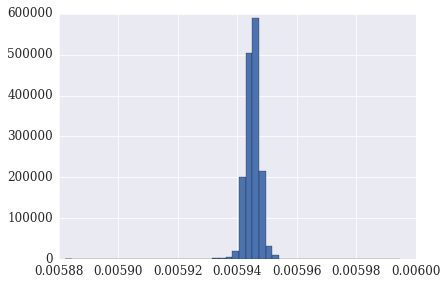

In [41]:
plt.hist(policy_bmf_flipped.ravel(), bins=50)
pass

The values for the learned policy are not very spread out

Scenario 4: Direct policy learning on original rating

In [42]:
params_bmf_org = BMF.LEARN(partial_org_observation, gpro_inv_org, mu, None, numDims, numRecs, False)
policy_bmf_org = BMF.PREDICTED_PROBABILITIES(*params_bmf_org)


BMF.LEARN: [DBG]	 Iter 0  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 1  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 2  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 3  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 4  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 5  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 6  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 7  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 8  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 Iter 9  	 Optimization result: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

BMF.LEARN: [DBG]	 I

In [43]:
metricValue = currMetric(complete_org_ratings, policy_bmf_org, None)[0]
metricValue = metricValue / numRecs
print "PolicyOpt: [LOG] Stochastic (original) \t Eventual result:", metricValue

PolicyOpt: [LOG] Stochastic (original) 	 Eventual result: 1.81925014206


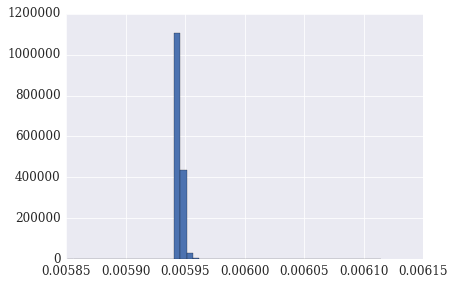

In [44]:
plt.hist(policy_bmf_org.ravel(), bins=50)
pass